In [15]:
%matplotlib widget

In [16]:
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')
plt.rcParams['savefig.bbox'] = None
plt.rcParams['savefig.pad_inches'] = 0.1

In [17]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        # Find side vectors
        lx1 = xk - xj
        ly1 = yk - yj
        lx2 = xi - xj
        ly2 = yi - yj
        # Compute area
        A[e] = (lx1*ly2 - lx2*ly1) / 2.0
    return A

In [18]:
def compute_elasticity_matrix(Ey, ν):
    D  = Ey / (1 - ν**2) * np.array([[1, ν, 0], [ν, 1, 0], [0, 0, (1 - ν) / 2]])
    return D

def compute_stiffness_matrix(V, T, D):
    N = len(V) # Total number of nodes in the mesh
    E = len(T) # Total number of triangles in the mesh

    Ke = np.zeros((6,   E*6), dtype=np.float64)
    K  = np.zeros((N*2, N*2), dtype=np.float64)

    A = compute_triangle_areas(V, T)

    # Now compute element stiffness matrices
    for e in range(E):
        # Get triangle indices
        i = T[e,0]  
        j = T[e,1]  
        k = T[e,2]  
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]
        
        # Compute spatial gradients of the barycentric coordinates
        A_ijk = A[e]
        
        D_Ni_x = -(yk - yj) / (2 * A_ijk)
        D_Nj_x = -(yi - yk) / (2 * A_ijk)
        D_Nk_x = -(yj - yi) / (2 * A_ijk)
        
        D_Ni_y = (xk - xj) / (2 * A_ijk)
        D_Nj_y = (xi - xk) / (2 * A_ijk)
        D_Nk_y = (xj - xi) / (2 * A_ijk) 
        
        # Compute the B matrix
        B = np.array([[D_Ni_x,  0,      D_Nj_x, 0,      D_Nk_x, 0     ],
                    [0,       D_Ni_y, 0,      D_Nj_y, 0,      D_Nk_y],
                    [D_Ni_y,  D_Ni_x, D_Nj_y, D_Nj_x, D_Nk_y, D_Nk_x]])
            
        # Compute element stiffness matrix and store it in Ke array
        Ke[:, 6*e:6*e+6] = B.T @ D @ B * A_ijk
        
    # Now do assembly process of global stiffness matrix
    for e in range(E):
        # Get global triangle vertex indices
        i = T[e,0]  
        j = T[e,1]  
        k = T[e,2]    
        # Local order of vertex coordinates is i_x, i_y, j_x j_y, k_x, and  k_y. 
        # This is how local vertex indices (0,1,2,..,5) are mapped to global vertex
        # indices
        gidx = [i, N + i, j, N + j, k, N + k]
        # Now we can add the element stiffness matrix to the global matrix using
        # our local-global vertex index mapping.
        
        # TODO - assemble Ke into global K matrix
        for p in range(6):
            for q in range(6):
                K[gidx[p], gidx[q]] += Ke[p, e*6 + q]
    
    return K

def plot_stiffness_matrix(K, title = None, plot_eigenvalues = False):
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.spy(K);
        ax.set_title(f'Fill pattern of stiffness matrix ({title})');
        ax.set_ylabel('Row index');
        ax.set_xlabel('Column index');
        plt.show()

        
        fig = plt.figure()
        d, _ = np.linalg.eig(K)
        plt.plot(np.sort( d ), '.', ms = 1);
        ax.set_title(f'Eigenvalues of stiffness matrix ({title})');
        ax.set_xlabel('Eigenvalue Index')
        ax.set_ylabel('Value');
        plt.show()
            
def solve_linear_system(V, K, f, boundary_indices, boundary_values):
    F = np.setdiff1d(np.arange(2*N), boundary_indices)
    
    u = np.zeros(f.shape, dtype=np.float64)
    u[boundary_indices] = boundary_values
    KFF = K[F, :][:, F]
    fF  = f[F]
    u[F] = np.linalg.solve(KFF, fF)

    x = V[:, 0] + u[0:N]
    y = V[:, 1] + u[N:2*N]
    return u, x, y

def plot_displacement(V, T, u, x, y, color, problem, load = None, figsize = (6, 6)):
    fig, ax = plt.subplots(figsize = figsize)
    ax.triplot(V[:, 0], V[:, 1], T, color='black', alpha=0.15, lw=0.5)
    ax.quiver(V[:, 0], V[:, 1], u[0:N], u[N:2*N], scale=1, scale_units='xy', color=color, width=0.003, alpha=0.5)
    ax.triplot(x, y, T, color='black', lw=0.8)
    
    if problem == 'cantilever':
        right_boundary_mask = V[:,0] == V[:,0].max()
        right_boundary_indices = np.array(np.where(right_boundary_mask), dtype=np.int32).flatten()
        right_boundary_points = np.array([V[:,0][right_boundary_indices] + u[right_boundary_indices], 
                                           V[:,1][right_boundary_indices] + u[right_boundary_indices + N]]).T
        ax.plot(right_boundary_points[:, 0], right_boundary_points[:, 1], 'r', label = 'load interface', lw = 1.5)
        ax.set_title(f'Displacement of cantilever with load')
    
    elif problem == 'settling':
        ax.set_title(f'Settling under gravity')
    
    elif problem == 'bridge':
        xlen = V[:,0].max() - V[:,0].min()
        middle_boundary_xmask = np.logical_and(V[:,0] > V[:,0].mean() - xlen * 0.2, V[:,0] < V[:, 0].mean() + xlen * 0.2)
        middle_boundary_mask = np.logical_and(middle_boundary_xmask, V[:,1] == V[:,1].max())

        middle_boundary_xindices = np.array(np.where(middle_boundary_mask), dtype=np.int32).flatten()
        middle_boundary_yindices = middle_boundary_xindices + N

        middle_boundary_points = np.array([V[:,0][middle_boundary_xindices] + u[middle_boundary_xindices], 
                                           V[:,1][middle_boundary_xindices] + u[middle_boundary_yindices]]).T
        
        # Plot the red lines between the middle boundary points
        ax.plot(middle_boundary_points[:, 0], middle_boundary_points[:, 1], 'r', label = 'load interface', lw = 1.5)
        
        ax.set_title(f'Displacement of bridge with load')       
    else:
        raise ValueError('Invalid problem type')
    ax.set_aspect('equal')
    plt.show()
    return fig, ax


In [19]:

def cantilever_boundary_conditions(V, K, ρ, load, g = 0):
    N = len(V)
    f = np.zeros((2*N,),dtype=np.float64)
    f[1::2] = - g * ρ

    right_boundary_indices = np.array(np.where(V[:,0] == V[:,0].max()), dtype=np.int32).flatten() + N
    f[right_boundary_indices] = load
        
    left_boundary_xindices = np.array(np.where(V[:,0] == V[:,0].min()), dtype=np.int32).flatten()
    left_boundary_yindices = left_boundary_xindices + N

    left_boundary_indices = np.hstack((left_boundary_xindices, left_boundary_yindices))
    left_boundary_values  = np.zeros(left_boundary_indices.shape, dtype=np.float64)

    F = np.setdiff1d(np.arange(2*N), left_boundary_indices)

    for i, (left_boundary_index, left_boundary_value) in enumerate(zip(left_boundary_indices, left_boundary_values)):
        # TODO - add boundary conditions here    
        # Moving known values to the right hand side
        f[F] -= K[F, left_boundary_index] * left_boundary_value
        f[left_boundary_index] = left_boundary_value
        
        # Inserting boundary conditions into K
        K[left_boundary_index, :] = 0
        K[left_boundary_index, left_boundary_index] = 1
    return K, f, left_boundary_indices, left_boundary_values
    
    
def solve_cantilever_problem(V, T, Ey, ν, ρ, load, color, do_plot_displacement = True, do_plot_stiffness_matrix = False):
    D = compute_elasticity_matrix(Ey, ν)
    K = compute_stiffness_matrix(V, T, D)
    K, f, left_boundary_indices, left_boundary_values = cantilever_boundary_conditions(V, K, ρ, load)
    
    if do_plot_stiffness_matrix:
        plot_stiffness_matrix(K, title)
    
    u, x, y = solve_linear_system(V, K, f, left_boundary_indices, left_boundary_values)
    
    if do_plot_displacement:
        fig, ax = plot_displacement(V, T, u, x, y, color, load = load, problem = 'cantilever')
        return fig, ax


In [20]:
def settling_boundary_conditions(V, K, ρ, g):
    N = len(V)
    f = np.zeros((2*N,),dtype=np.float64)
    f[1::2] = -g * ρ
        
    lower_boundary_xindices = np.array(np.where(V[:,1] == V[:,1].min()), dtype=np.int32).flatten()
    lower_boundary_yindices = lower_boundary_xindices + N

    lower_boundary_indices = np.hstack((lower_boundary_xindices, lower_boundary_yindices))
    lower_boundary_values  = np.zeros(lower_boundary_indices.shape, dtype=np.float64)

    F = np.setdiff1d(np.arange(2*N), lower_boundary_indices)

    for i, (lower_boundary_index, lower_boundary_value) in enumerate(zip(lower_boundary_indices, lower_boundary_values)):
        # add boundary conditions here    
        # Moving known values to the right hand side
        f[F] -= K[F, lower_boundary_index] * lower_boundary_value
        f[lower_boundary_index] = lower_boundary_value
        
        # Inserting boundary conditions into K
        K[lower_boundary_index, :] = 0
        K[lower_boundary_index, lower_boundary_index] = 1
    return K, f, lower_boundary_indices, lower_boundary_values
        
        
def solve_settling_problem(V, T, Ey, ν, ρ, color, do_plot_displacement = True, do_plot_stiffness_matrix = False):
    D = compute_elasticity_matrix(Ey, ν)
    K = compute_stiffness_matrix(V, T, D)
    K, f, lower_boundary_indices, lower_boundary_values = settling_boundary_conditions(V, K, ρ, g)
    
    if do_plot_stiffness_matrix:
        plot_stiffness_matrix(K, title)
    
    u, x, y = solve_linear_system(V, K, f, lower_boundary_indices, lower_boundary_values)
    
    if do_plot_displacement:
        fig, ax = plot_displacement(V, T, u, x, y, color, problem = 'settling')
        return fig, ax

In [21]:
def bridge_boundary_conditions(V, K, ρ, load, g = 9.81):
    N = len(V)
    f = np.zeros((2*N,),dtype=np.float64)
    f[1::2] = - g * ρ

    right_boundary_xindices = np.array(np.where(V[:,0] == V[:,0].max()), dtype=np.int32).flatten()
    right_boundary_yindices = right_boundary_xindices + N
    right_boundary_indices = np.hstack((right_boundary_xindices, right_boundary_yindices))
    right_boundary_values  = np.zeros(right_boundary_indices.shape, dtype=np.float64)
        
    left_boundary_xindices = np.array(np.where(V[:,0] == V[:,0].min()), dtype=np.int32).flatten()
    left_boundary_yindices = left_boundary_xindices + N
    left_boundary_indices = np.hstack((left_boundary_xindices, left_boundary_yindices))
    left_boundary_values  = np.zeros(left_boundary_indices.shape, dtype=np.float64)

    left_right_boundary_indices = np.hstack((left_boundary_indices, right_boundary_indices))
    left_right_boundary_values  = np.hstack((left_boundary_values, right_boundary_values))

    xlen = V[:,0].max() - V[:,0].min()
    middle_boundary_xmask = np.logical_and(V[:,0] > V[:,0].mean() - xlen * 0.2, V[:,0] < V[:, 0].mean() + xlen * 0.2)
    middle_boundary_mask = np.logical_and(middle_boundary_xmask, V[:,1] == V[:,1].max())

    middle_boundary_xindices = np.array(np.where(middle_boundary_mask), dtype=np.int32).flatten()
    middle_boundary_yindices = middle_boundary_xindices + N
    middle_boundary_indices = np.hstack((middle_boundary_xindices, middle_boundary_yindices))
    f[middle_boundary_indices] = load

    F = np.setdiff1d(np.arange(2*N), left_right_boundary_indices)

    for i, (left_right_boundary_index, left_right_boundary_value) in enumerate(zip(left_right_boundary_indices, left_right_boundary_values)):
        # TODO - add boundary conditions here    
        # Moving known values to the right hand side
        f[F] -= K[F, left_right_boundary_index] * left_right_boundary_value
        f[left_right_boundary_index] = left_right_boundary_value
        
        # Inserting boundary conditions into K
        K[left_right_boundary_index, :] = 0
        K[left_right_boundary_index, left_right_boundary_index] = 1
    return K, f, left_right_boundary_indices, left_right_boundary_values
        
        
def solve_bridge_problem(V, T, Ey, ν, ρ, load, color, do_plot_displacement = True, do_plot_stiffness_matrix = False):
    D = compute_elasticity_matrix(Ey, ν)
    K = compute_stiffness_matrix(V, T, D)
    K, f, left_right_boundary_indices, left_right_boundary_values = bridge_boundary_conditions(V, K, ρ, load, g)
    
    if do_plot_stiffness_matrix:
        plot_stiffness_matrix(K, title)
    
    u, x, y = solve_linear_system(V, K, f, left_right_boundary_indices, left_right_boundary_values)
    
    if do_plot_displacement:
        fig, ax = plot_displacement(V, T, u, x, y, color, load = load, problem = 'bridge', figsize = (8, 3))
        return fig, ax

# Experiment 1: Cantilever

In [22]:
savefigs = False

In [23]:
doExp1 = True

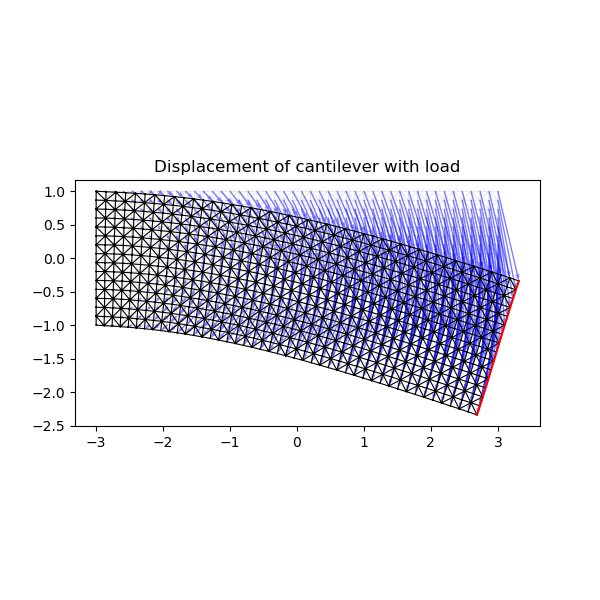

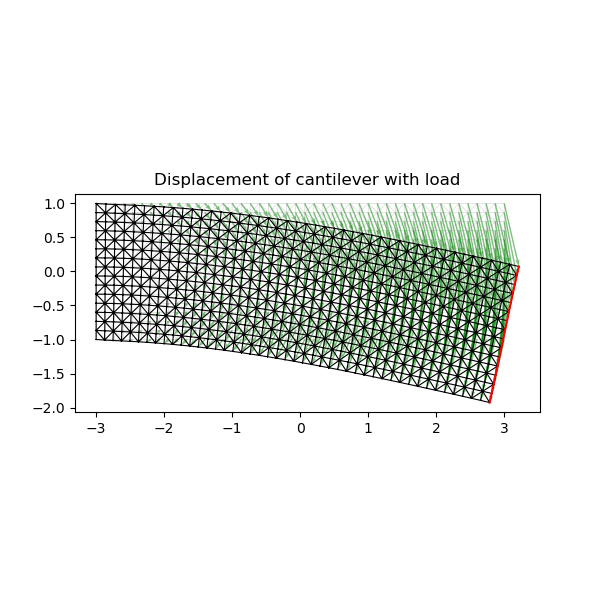

In [24]:
if doExp1:
    Ey_alu = 69e9  # Young modulus for aluminium
    ν_alu = 0.3    # Poisson ration for aluminium
    ρ_alu = 2700 # Density of aluminium in kg/m^3

    Ey_rub = 0.01e9 # Young modulus for rubber
    ν_rub = 0.49 # Poisson ratio for rubber
    ρ_rub = 1100 # Density of rubber in kg/m^3

    Es = [Ey_alu, Ey_rub]
    νs = [ν_alu, ν_rub]
    ρs = [ρ_alu, ρ_rub]

    loads = [-5e7, -5e3] # Load applied to the cantilever in N

    materials = ['Aluminium', 'Rubber']
    colors = ['blue', 'green']

    Ks = []
    fs = []
    us = []

    for i, (Ey, ν, ρ, load, material, color) in enumerate(zip(Es, νs, ρs, loads, materials, colors)):
        width = 6.0
        height = 2.0
        aspect = width / height
        I = int(15 * aspect)
        J = int(15)
        V, T = make_beam_mesh(width, height, (I, J))

        N = len(V)
        fig, ax = solve_cantilever_problem(V, T, Ey, ν, ρ, load, color)
        ax.legend(loc = 'lower left')
        meta_data = {'Problem':'Cantilever', 'Material': str(material), 'Load': str(int(np.abs(load)/1e3)) + ' kN'}
        text_str = '\n'.join([f'{k}:\n{v}\n' for k, v in meta_data.items()])

        ax.text(1.01, 1.0, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
        fig.subplots_adjust(left=0.1, right=0.7, top=1.0, bottom=0.1)
        
        if savefigs:
            fig.savefig(f'Images/exp1/exp1_{i}', dpi=300, metadata=meta_data, bbox_inches='tight', pad_inches=0.1)
            

# Experiment 2: Settling under gravity

In [25]:
doExp2 = True

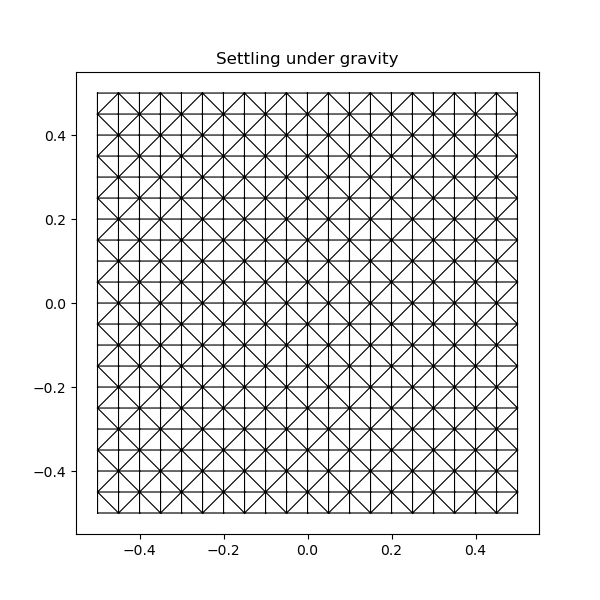

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


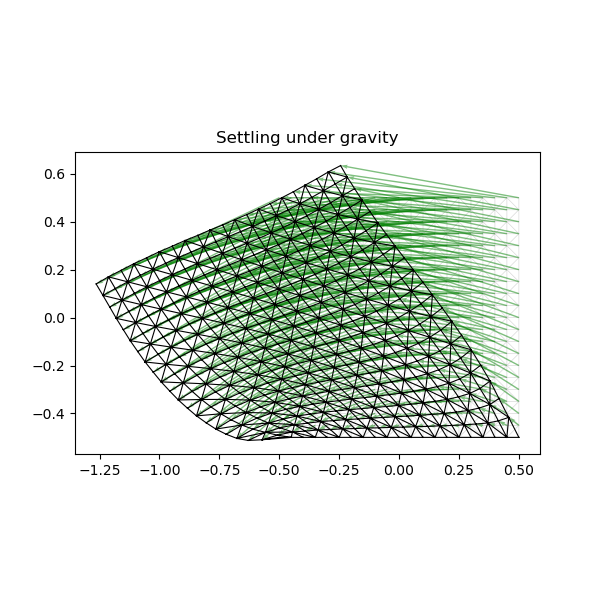

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [26]:
if doExp2:
    g = 9.81 #m/s^2

    Ey_alu = 69e9  # Young modulus for aluminium
    ν_alu = 0.3    # Poisson ration for aluminium
    ρ_alu = 2700 # Density of aluminium in kg/m^3

    Ey_rub = 0.01e9 # Young modulus for rubber
    ν_rub = 0.49 # Poisson ratio for rubber
    ρ_rub = 1100 # Density of rubber in kg/m^3

    Es = [Ey_alu, Ey_rub]
    νs = [ν_alu, ν_rub]
    ρs = [ρ_alu, ρ_rub]

    materials =['Aluminium','Rubber']
    colors = ['blue', 'green']
    
    width = 1.0
    height = 1.0
    aspect = width / height
    I = int(20 * aspect)
    J = int(20)
    V, T = make_beam_mesh(width, height, (I, J))
    N = len(V)

    for i, (Ey, ν, ρ, material, color) in enumerate(zip(Es, νs, ρs, materials, colors)):
        fig, ax = solve_settling_problem(V, T, Ey, ν, ρ, color)
        
        meta_data = {'Problem':'Settling', 'Material': str(material), 'Load': str(int(np.abs(load)/1e3)) + ' kN'}
        text_str = '\n'.join([f'{k}:\n{v}\n' for k, v in meta_data.items()])

        fig.subplots_adjust(left=0.1, right=0.7, top=1.0, bottom=0.1)
        ax.text(1.01, 1.0, text_str, transform=ax.transAxes, fontsize=15, verticalalignment='top')
        
        # Change the font size of the title
        ax.title.set_size(20)

        # Change the font size of the x and y labels
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)

        # Change the font size of the tick labels
        ax.tick_params(axis='both', which='major', labelsize=15)

        # Change the font size of the legend
        legend = ax.legend()
        plt.setp(legend.get_texts(), fontsize='15')
        
        if savefigs:
            fig.savefig(f'Images/exp2/exp2_{i}', dpi=300, metadata=meta_data, bbox_inches='tight', pad_inches=0.1)
            

# Experiment 3: Bridge stress

In [27]:
doExp3 = True


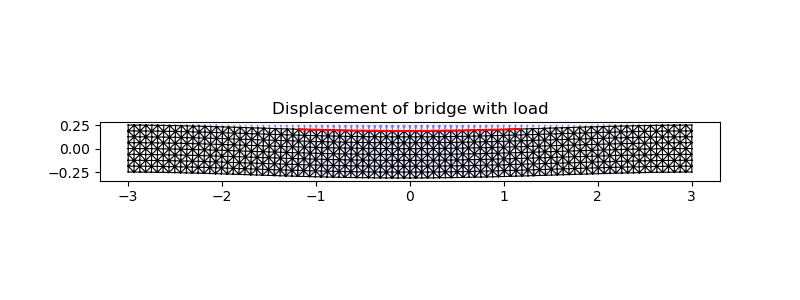

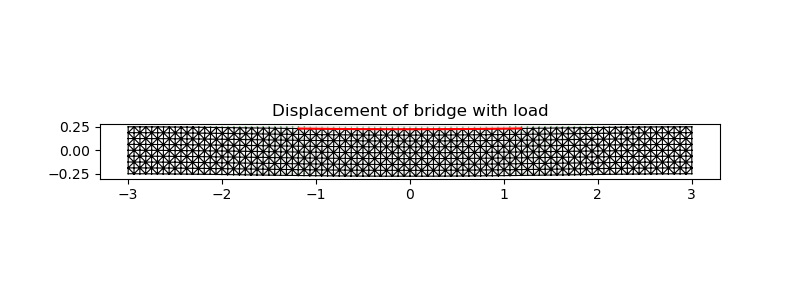

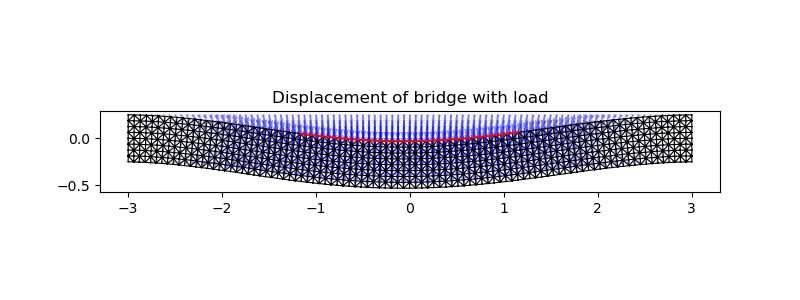

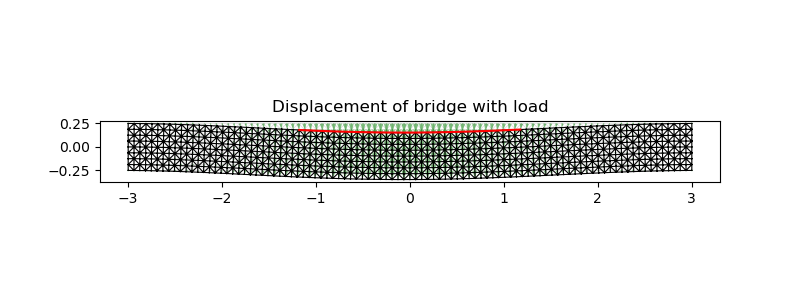

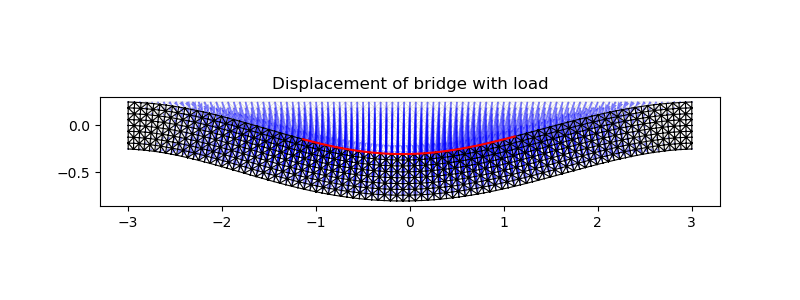

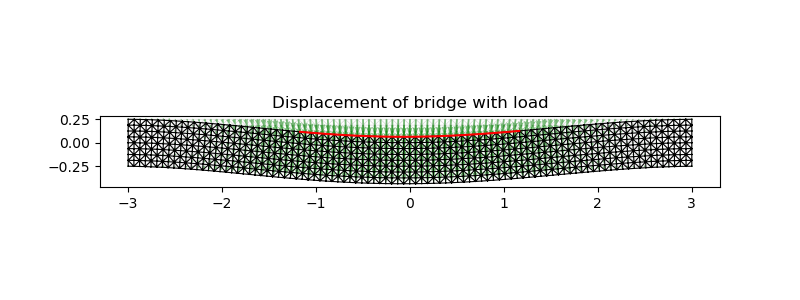

In [28]:
if doExp3:
    g = 9.81 #m/s^2

    Ey_alu = 69e9  # Young modulus for aluminium
    ν_alu = 0.3    # Poisson ration for aluminium
    ρ_alu = 2700 # Density of aluminium in kg/m^3

    Ey_iron = 211e9  # Young modulus for iron
    ν_iron = 0.29    # Poisson ration for iron
    ρ_iron = 7850  # Density of iron in kg/m^3

    Es = [Ey_alu, Ey_iron]
    νs = [ν_alu, ν_iron]
    ρs = [ρ_alu, ρ_iron]
    materials =['Aluminium', 'Iron']
    colors =['blue', 'green']
    
    width = 6.0
    height = 0.5
    aspect = width / height
    I = int(8 * aspect)
    J = int(8)
    V, T = make_beam_mesh(width, height, (I, J))
    N = len(V)
    
    LOADS = [-1e6, -5e6, -1e7] # Load applied to the cantilever in N

    for i, LOAD in enumerate(LOADS):
        loads = [LOAD, LOAD]
        for j, (Ey, ν, ρ, load, material, color) in enumerate(zip(Es, νs, ρs, loads, materials, colors)):
            fig, ax = solve_bridge_problem(V, T, Ey, ν, ρ, load, color)
            ax.set_xlim(-3*width/5, 3*width/5)
            ylim = ax.get_ylim()
            ax.set_ylim(np.min(ylim)*2, -np.min(ylim)*2)
            ax.legend(loc = 'upper right')
            fig.set_size_inches(8, 4)
            
            meta_data = {'Problem':'Settling', 'Material': str(material), 'Load': str(int(np.abs(load)/1e3)) + ' kN'}
            text_str = '\n'.join([f'{k}:\n{v}\n' for k, v in meta_data.items()])

            ax.text(1.01, 1.0, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
            fig.subplots_adjust(left=0.1, right=0.7, top=1.0, bottom=0.1)
            
            # Change the font size of the title
            ax.title.set_size(15)

            # Change the font size of the x and y labels
            ax.xaxis.label.set_size(15)
            ax.yaxis.label.set_size(15)

            # Change the font size of the tick labels
            ax.tick_params(axis='both', which='major', labelsize=10)

            # Change the font size of the legend
            legend = ax.legend(loc = 'upper right')
            plt.setp(legend.get_texts(), fontsize='10')
            
            if savefigs:
                fig.savefig(f'Images/exp3/exp3_{i}{j}', dpi=300, metadata=meta_data, bbox_inches='tight', pad_inches=0.1)
            